In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json
import datetime
import random

seed=117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:

def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

def read_onehot():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/onehot_data.json', 'r') as infile:
    onehot_map = json.load(infile)
    onehot_map.update((acc, np.array(onehot)) for acc, onehot in onehot_map.items())
    return onehot_map

def read_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_homo_solution():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/homo_solution.json', 'r') as infile:
    return json.load(infile)

# Protein sequences
protein_sequences_n_ids = read_sequences()
# IDRs
pandas_data_IDRs = read_cleaned_pandas_data()
# One-hot features
onehot_map = read_onehot()
# PSSM features
pssm_map = read_pssms()
# Randomly sampled dataset split from pre-processing.
# Data leakage prevention included.
non_leaking_dataset_split = read_homo_solution()

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [4]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = pandas_table
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        # Each row must have a unique accession number, hence we can 0 index this list
        dataframe_idx = self.disorder_prot.index[self.disorder_prot['acc'] == acc].tolist()[0]
        idrs = self.disorder_prot['disordered_regions'].loc[dataframe_idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

### Training model, given DisProt dataset

Separate train/validation/test datasets, with a 60/20/20 split.

One-hot feature encoding.

In [5]:
train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

PSSM feature encoding.

In [ ]:
train_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])

train_pssm_loader = DataLoader(train_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_pssm_loader = DataLoader(validation_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_pssm_loader = DataLoader(test_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

### Working with a PyTorch NN. RNN model

In [6]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 20 inputs - for each amino acid
        self.input_dim = 20
        self.hidden_dim = 32
        self.num_layers = 2
        self.rnn1 = nn.LSTM(input_size=20, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim*2, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 1)
        #self.sig1 = nn.Sigmoid()

    def init_hidden(self, batch_size):
        # Initialise hidden state
        return (torch.zeros(self.num_layers*2, batch_size, self.hidden_dim).cuda(), 
                torch.zeros(self.num_layers*2, batch_size, self.hidden_dim).cuda())

    def forward(self, x):
      batch_size = x.size(0)
      h    = self.init_hidden(batch_size)

      y, h = self.rnn1(x,h)
      y = self.relu1(self.linear(y))
      y = self.linear2(y)
      
      return y, h

#### Evaluating with the Matthews correlation coefficient.
- This can be used with the validation dataset each epoch.
- This is used to evaluate the test dataset.

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

In [7]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def calc_MCC(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  # Calculating FP
  FP = (true_label[predicted_label == 1] == 0).sum()

  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  return MCC

#### Counteracting the unbalanced dataset
- Generate a weight given the ratio of ordered to disordered amino acids.

In [8]:
def loss_weight_multiplier(loader):
  total_amino_acids = 0
  total_disordered_AA = 0
  for i, sam in enumerate(loader):
    lab = torch.squeeze(sam.get('label'))
    total_amino_acids += len(lab)
    total_disordered_AA += sum(lab)

  disordered_ratio = total_disordered_AA / total_amino_acids
  disordered_loss_weight = 1 / disordered_ratio
  return disordered_loss_weight

#### Using the Validation dataset
- Can monitor validation loss compared to training loss to prevent overfitting.
- This train and validation loop will give us results to plot the loss curves for the train and validation datasets per epoch.
- The MCC is also calculated on the validation set, given the model each epoch.

In [ ]:
epoch_print_gap = 20

def train_validation_loop_with_mcc(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader, device):
    model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        model.train()
        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          # Einsum to flip axis dimensions suitable to rnn input
          seq = torch.einsum('ijk->ikj', seq)
          # Move features and labels to PyTorch tensors and cuda
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          # Output is the predictions
          output, _ = model(NN_input)
          # Squeeze as we are treating each sequence as a batch, where the amino acids have been classified
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()        
          loss.backward()
          optimizer.step()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()
          
          # Print loss throughout epoch. Lets us see no 'batches' of the data are causing drastic issues.
          # Shows loss per 400 sequences of each epoch, so we can see loss throughout training.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0
        
        # Validation data handling
        model.eval()
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          seq = torch.einsum('ijk->ikj', seq)
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output, _ = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(torch.sigmoid(squeezed_o)), squeezed_e_o)

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "finished with", (total_epoch_loss/len(train_loader))," \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )
        epoch_valid_loss_arr.append( (total_loss_valid / len(valid_loader)) )
        epoch_valid_MCC_arr.append( (total_MCC_valid / len(valid_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 100
new_model = RNN_Net()
optimizer = optim.SGD(new_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_model, criterion, train_loader, validation_loader, device)


Epoch: 0 Current loss: 1.4124639566242694
Epoch: 0 Current loss: 1.3809135189652444
Epoch: 0 Current loss: 1.39028790473938
Epoch 0 finished with 1.3905223647726657  


Epoch: 20 Current loss: 1.3813425609469414
Epoch: 20 Current loss: 1.3959127750992775
Epoch: 20 Current loss: 1.37634145706892
Epoch 20 finished with 1.3851810587848339  


Epoch: 40 Current loss: 1.2561230541765689
Epoch: 40 Current loss: 1.2422624544799328
Epoch: 40 Current loss: 1.1853865744173526
Epoch 40 finished with 1.2278661376334135  


Epoch: 60 Current loss: 1.1999129630625247
Epoch: 60 Current loss: 1.1500562889873982
Epoch: 60 Current loss: 1.1614039251953363
Epoch 60 finished with 1.1604563667066645  


Epoch: 80 Current loss: 1.1373781636357307
Epoch: 80 Current loss: 1.1508734084665775
Epoch: 80 Current loss: 1.14134431168437
Epoch 80 finished with 1.144483575850605  




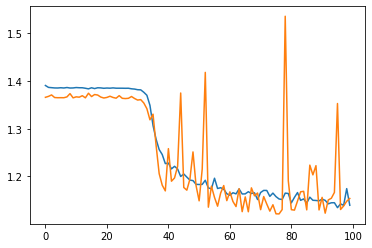

In [ ]:
plt.plot(range(epochs), epoch_loss_arr)
plt.plot(range(epochs), epoch_valid_loss_arr)
plt.show()

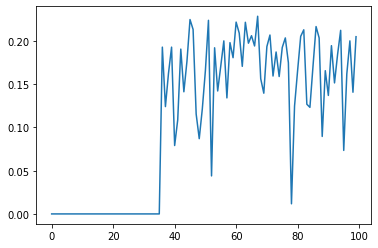

In [ ]:
epoch_valid_MCC_arr_plottable = [epoch_valid_MCC_arr[i].to('cpu').numpy() if epoch_valid_MCC_arr[i] != 0 else 0.0 for i, se in enumerate(epoch_valid_MCC_arr)]
plt.plot(range(epochs), epoch_valid_MCC_arr_plottable)
plt.show()

And the PSSM model

Epoch: 0 Current loss: 1.4038940672576428
Epoch: 0 Current loss: 1.404339965581894
Epoch: 0 Current loss: 1.3536174044013023
Epoch 0 finished with 1.3862244500847556  


Epoch: 20 Current loss: 1.1191544265300035
Epoch: 20 Current loss: 1.0825163493305445
Epoch: 20 Current loss: 1.0875702107697724
Epoch 20 finished with 1.0876435628649685  


Epoch: 40 Current loss: 1.0493839560449123
Epoch: 40 Current loss: 1.0920394260436297
Epoch: 40 Current loss: 1.007513919211924
Epoch 40 finished with 1.0601753163706726  


Epoch: 60 Current loss: 0.9605363664403558
Epoch: 60 Current loss: 1.084945173636079
Epoch: 60 Current loss: 1.091023180708289
Epoch 60 finished with 1.0460236807771197  


Epoch: 80 Current loss: 1.0556761970371007
Epoch: 80 Current loss: 1.0677541229873895
Epoch: 80 Current loss: 1.0282757705450059
Epoch 80 finished with 1.0334031115189535  




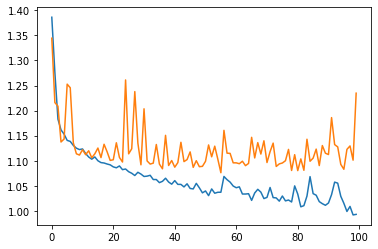

In [ ]:
lamb=0.001
lr = 0.001
epochs = 100
new_pssm_model = RNN_Net()
optimizer = optim.SGD(new_pssm_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

epoch_loss_arr = []
epoch_valid_loss_arr = []
epoch_valid_MCC_arr = []
train_validation_loop_with_mcc(epochs, optimizer, new_pssm_model, criterion, train_pssm_loader, validation_pssm_loader, device)

plt.plot(range(epochs), epoch_loss_arr)
plt.plot(range(epochs), epoch_valid_loss_arr)
plt.show()

#### Tuning Hyperparameters

In [ ]:
#pip install -U ray

In [ ]:
# Note ray often needs to be reinstalled, so uncomment and install this if the following imports do not work
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

From our above analysis of manually changing parameters we see improvements to the loss are made slowly for some values with our one-hot encoding. Furthermore, the LSTM can be run for a lot more epochs than the CNN model before overfitting, hence our justification for a larger grace period. We also see that ~100 epochs and the improvements to the validation set begins nearing convergence, therefore we will choose to evaluate the model for 100 epochs. For the pssm model, these epochs will be lowered to 20. From manual experimentation we also see a low learning rate is more optimal, therefore we have selected values in this range to be experimented on. A larger (but still small) weight decay was important for our models using PSSM input.

In [ ]:
def train_and_eval(config):
    
    # Call the remote function and pass in the object reference as memory issues occur trying to access the global variables, or passing them in locally
    train_loader = ray.get(train_object_ref)
    valid_loader = ray.get(validation_object_ref)

    lamb = config['lamb']
    lr = config['lr']
    epochs = config['epochs']
    model = RNN_Net()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
    use_cuda = True
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    disordered_loss_weight = loss_weight_multiplier(train_loader)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))
    
    model = model.to(device)
    best_val_loss = float('inf')
    for epoch in range(0, epochs):

        # Training data handling
        total_epoch_loss = 0.0
        train_iter = iter(train_loader)

        model.train()
        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          seq = torch.einsum('ijk->ikj', seq)
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          output, _ = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()
          loss.backward()
          total_epoch_loss += loss.item()
          optimizer.step()
        

        # Validation data handling
        model.eval()
        valid_iter = iter(valid_loader)
        total_loss_valid = 0
        total_MCC_valid = 0
        for i, sam in enumerate(valid_iter):
          acc, seq, label = sam.values()
          seq = torch.einsum('ijk->ikj', seq)
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          with torch.no_grad():
            output, _ = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          total_loss_valid += loss.item()

          total_MCC_valid += calc_MCC(pred_round(torch.sigmoid(squeezed_o)), squeezed_e_o)

        # Validation statistics for selecting best hyperparameters
        average_loss = total_loss_valid / len(valid_loader)
        average_mcc = total_MCC_valid / len(valid_loader)

        if average_loss < best_val_loss:
          best_val_loss = average_loss
          with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = drive_checkpoint_dir + '/checkpoint'
            torch.save(model.state_dict(), path)

        tune.report(loss=best_val_loss) #, mcc=average_mcc)


In [ ]:
config = {
    "lr": tune.choice([0.0005, 0.001, 0.005]),
    "lamb": tune.choice([0.001, 0.005, 0.01]),
    "epochs": 100
}

ray.init(num_gpus=1, ignore_reinit_error=True)

# Create references for data loaders due to memory issues
train_object_ref = ray.put(train_loader)
validation_object_ref = ray.put(validation_loader)

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=40
)

reporter = CLIReporter()

drive_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/ray_results'

analysis = tune.run(
    train_and_eval,
    config=config,
    resources_per_trial=tune.PlacementGroupFactory(
        [{'GPU': 1.0, 'CPU': 1.0}] + [{'CPU': 1.0}] * 1
    ),
    num_samples=10,
    local_dir=drive_checkpoint_dir,
    scheduler=scheduler,
    progress_reporter=reporter,
)


2023-03-14 20:41:24,924	INFO worker.py:1553 -- Started a local Ray instance.
2023-03-14 20:41:27,565	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2023-03-14 20:41:27,568	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-14 20:41:30 (running for 00:00:02.92)
Memory usage on this node: 5.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+
| Trial name                 | status   | loc               |   lamb |     lr |
|----------------------------+----------+-------------------+--------+--------|
| train_and_eval_97d02_00000 | RUNNING  | 172.28.0.12:14214 |  0.001 | 0.005  |
| train_and_eval_97d02_00001 | PENDING  |                   |  0.005 | 0.001  |
| train_and_eval_97d02_00002 | PENDING  |                   |  0.01  | 0.0005 |
| train_and_eval_97d02_00003 | PENDING  |                   |  0.01  | 0.005  |
| train_and_eval_97d02_00004 | 

(train_and_eval pid=14214) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=14214)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 20:41:35 (running for 00:00:07.93)
Memory usage on this node: 6.5/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+
| Trial name                 | status   | loc               |   lamb |     lr |
|----------------------------+----------+-------------------+--------+--------|
| train_and_eval_97d02_00000 | RUNNING  | 172.28.0.12:14214 |  0.001 | 0.005  |
| train_and_eval_97d02_00001 | PENDING  |                   |  0.005 | 0.001  |
| train_and_eval_97d02_00002 | PENDING  |                   |  0.01  | 0.0005 |
| train_and_eval_97d02_00003 | PENDING  |                   |  0.01  | 0.005  |
| train_and_eval_97d02_00004 | 

== Status ==
Current time: 2023-03-14 20:41:56 (running for 00:00:28.49)
Memory usage on this node: 7.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status   | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+----------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00000 | RUNNING  | 172.28.0.12:14214 |  0.001 | 0.005  |      1 |          20.5343 | 1.37871 |
| train_and_eval_97d02_00001 | PENDING  |                   |  0.005 | 0.001  |        |                  |         |
|

(train_and_eval pid=19825) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=19825)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 21:03:15 (running for 00:21:47.23)
Memory usage on this node: 5.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: -1.3649358548533734
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00001 | RUNNING    | 172.28.0.12:19825 |  0.005 | 0.001  |        |                  |         |
| train_and_eval_97d02_00002 | PENDING    |                   |  0.01  | 0.0005 | 

(train_and_eval pid=22103) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=22103)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 21:12:02 (running for 00:30:34.31)
Memory usage on this node: 5.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 40.000: -1.3649471254134857
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00002 | RUNNING    | 172.28.0.12:22103 |  0.01  | 0.0005 |        |                  |         |
| train_and_eval_97d02_00003 | PENDING    |                   |  0.01  | 0.005  | 

(train_and_eval pid=24437) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=24437)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 21:21:01 (running for 00:39:33.42)
Memory usage on this node: 5.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 40.000: -1.364958395973598
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00003 | RUNNING    | 172.28.0.12:24437 |  0.01  | 0.005  |        |                  |         |
| train_and_eval_97d02_00004 | PENDING    |                   |  0.01  | 0.005  |  

(train_and_eval pid=26712) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=26712)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 21:29:48 (running for 00:48:20.54)
Memory usage on this node: 5.2/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 40.000: -1.3649653049605681
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00004 | RUNNING    | 172.28.0.12:26712 |  0.01  | 0.005  |        |                  |         |
| train_and_eval_97d02_00005 | PENDING    |                   |  0.005 | 0.001  | 

(train_and_eval pid=29005) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=29005)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 21:38:34 (running for 00:57:06.63)
Memory usage on this node: 5.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 40.000: -1.3649751216629662
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00005 | RUNNING    | 172.28.0.12:29005 |  0.005 | 0.001  |        |                  |         |
| train_and_eval_97d02_00006 | PENDING    |                   |  0.01  | 0.005  | 

(train_and_eval pid=34842) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=34842)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 22:01:18 (running for 01:19:50.89)
Memory usage on this node: 5.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 40.000: -1.3649660915592827
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00006 | RUNNING    | 172.28.0.12:34842 |  0.01  | 0.005  |        |                  |         |
| train_and_eval_97d02_00007 | PENDING    |                   |  0.005 | 0.0005 | 

(train_and_eval pid=37166) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=37166)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 22:10:16 (running for 01:28:48.96)
Memory usage on this node: 5.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 40.000: -1.3649691015938439
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00007 | RUNNING    | 172.28.0.12:37166 |  0.005 | 0.0005 |        |                  |         |
| train_and_eval_97d02_00008 | PENDING    |                   |  0.005 | 0.001  | 

(train_and_eval pid=39479) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=39479)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 22:19:11 (running for 01:37:44.07)
Memory usage on this node: 5.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 40.000: -1.364972111628405
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00008 | RUNNING    | 172.28.0.12:39479 |  0.005 | 0.001  |        |                  |         |
| train_and_eval_97d02_00009 | PENDING    |                   |  0.001 | 0.001  |  

(train_and_eval pid=45148) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=45148)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-14 22:41:20 (running for 01:59:52.26)
Memory usage on this node: 5.3/12.7 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 40.000: -1.364964945050246
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00009 | RUNNING    | 172.28.0.12:45148 |  0.001 | 0.001  |        |                  |         |
| train_and_eval_97d02_00000 | TERMINATED | 172.28.0.12:14214 |  0.001 | 0.005  |    100 |    

2023-03-14 23:03:33,889	INFO tune.py:798 -- Total run time: 8526.35 seconds (8525.94 seconds for the tuning loop).


== Status ==
Current time: 2023-03-14 23:03:33 (running for 02:22:06.01)
Memory usage on this node: 6.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 40.000: -1.3649635474061026
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-14_20-41-27
Number of trials: 10/10 (10 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_97d02_00000 | TERMINATED | 172.28.0.12:14214 |  0.001 | 0.005  |    100 |         1298.44  | 1.36494 |
| train_and_eval_97d02_00001 | TERMINATED | 172.28.0.12:19825 |  0.005 | 0.001  |     40 |          523.62

Our best parameters:

In [ ]:
best_trial = analysis.get_best_trial(metric="loss", mode="min")
print(best_trial)
best_config = best_trial.config
print(best_config)
best_lamb = best_trial.config["lamb"]
print(best_lamb)
best_lr = best_trial.config["lr"]
print(best_lr)

train_and_eval_97d02_00009
{'lr': 0.001, 'lamb': 0.001, 'epochs': 100}
0.001
0.001


And PSSMs.

In [ ]:
config = {
    "lr": tune.choice([0.0005, 0.0075, 0.001, 0.0025]),
    "lamb": tune.choice([0.0025, 0.005, 0.01]),
    "epochs": 100
}

ray.init(num_gpus=1, ignore_reinit_error=True)

# Create references for data loaders due to memory issues
train_object_ref = ray.put(train_pssm_loader)
validation_object_ref = ray.put(validation_pssm_loader)

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    grace_period=20
)

reporter = CLIReporter()

drive_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/ray_results'

pssm_analysis = tune.run(
    train_and_eval,
    config=config,
    resources_per_trial=tune.PlacementGroupFactory(
        [{'GPU': 1.0, 'CPU': 1.0}] + [{'CPU': 1.0}] * 1
    ),
    num_samples=10,
    local_dir=drive_checkpoint_dir,
    scheduler=scheduler,
    progress_reporter=reporter,
)

2023-03-15 10:35:29,966	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.
2023-03-15 10:35:31,080	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-15 10:35:34 (running for 00:00:03.80)
Memory usage on this node: 3.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 20.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+------------------+--------+--------+
| Trial name                 | status   | loc              |   lamb |     lr |
|----------------------------+----------+------------------+--------+--------|
| train_and_eval_1c128_00000 | RUNNING  | 172.28.0.12:2347 | 0.0025 | 0.0075 |
| train_and_eval_1c128_00001 | PENDING  |                  | 0.01   | 0.0005 |
| train_and_eval_1c128_00002 | PENDING  |                  | 0.0025 | 0.001  |
| train_and_eval_1c128_00003 | PENDING  |                  | 0.01   | 0.0005 |
| train_and_eval_1

(train_and_eval pid=2347) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=2347)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 10:35:39 (running for 00:00:08.80)
Memory usage on this node: 4.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 20.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+------------------+--------+--------+
| Trial name                 | status   | loc              |   lamb |     lr |
|----------------------------+----------+------------------+--------+--------|
| train_and_eval_1c128_00000 | RUNNING  | 172.28.0.12:2347 | 0.0025 | 0.0075 |
| train_and_eval_1c128_00001 | PENDING  |                  | 0.01   | 0.0005 |
| train_and_eval_1c128_00002 | PENDING  |                  | 0.0025 | 0.001  |
| train_and_eval_1c128_00003 | PENDING  |                  | 0.01   | 0.0005 |
| train_and_eval_1

== Status ==
Current time: 2023-03-15 10:35:59 (running for 00:00:28.09)
Memory usage on this node: 5.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 20.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------------+----------+------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status   | loc              |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+----------+------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00000 | RUNNING  | 172.28.0.12:2347 | 0.0025 | 0.0075 |      1 |          19.2521 | 1.24807 |
| train_and_eval_1c128_00001 | PENDING  |                  | 0.01   | 0.0005 |        |                

(train_and_eval pid=8083) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=8083)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 10:57:45 (running for 00:22:14.48)
Memory usage on this node: 3.6/12.7 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: -1.1383178884925675 | Iter 20.000: -1.15775375658365
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------+------------+------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc              |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00001 | RUNNING    | 172.28.0.12:8083 | 0.01   | 0.0005 |        |                  |         |
| train_and_eval_1c128_00002 | PENDING    |          

(train_and_eval pid=13585) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=13585)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 11:19:09 (running for 00:43:38.74)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -1.109585009417466 | Iter 20.000: -1.1325119061627849
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00002 | RUNNING    | 172.28.0.12:13585 | 0.0025 | 0.001  |        |                  |         |
| train_and_eval_1c128_00003 | PENDING    |     

(train_and_eval pid=19099) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=19099)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 11:40:36 (running for 01:05:05.03)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -1.091058739263328 | Iter 20.000: -1.10492905244003
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00003 | RUNNING    | 172.28.0.12:19099 | 0.01   | 0.0005 |        |                  |         |
| train_and_eval_1c128_00004 | PENDING    |       

(train_and_eval pid=20289) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=20289)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 11:45:03 (running for 01:09:32.04)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.091058739263328 | Iter 20.000: -1.114513504231263
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00004 | RUNNING    | 172.28.0.12:20289 | 0.005  | 0.0005 |        |                  |         |
| train_and_eval_1c128_00005 | PENDING    |      

(train_and_eval pid=24809) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=24809)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 12:02:26 (running for 01:26:55.21)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.0898833971967843 | Iter 20.000: -1.110348401562651
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00005 | RUNNING    | 172.28.0.12:24809 | 0.01   | 0.0025 |        |                  |         |
| train_and_eval_1c128_00006 | PENDING    |     

(train_and_eval pid=25994) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=25994)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 12:06:53 (running for 01:31:22.28)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.0898833971967843 | Iter 20.000: -1.1137857901776123
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00006 | RUNNING    | 172.28.0.12:25994 | 0.005  | 0.0005 |        |                  |         |
| train_and_eval_1c128_00007 | PENDING    |    

(train_and_eval pid=27186) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=27186)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 12:11:22 (running for 01:35:51.27)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.0898833971967843 | Iter 20.000: -1.1132004848911672
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00007 | RUNNING    | 172.28.0.12:27186 | 0.0025 | 0.001  |        |                  |         |
| train_and_eval_1c128_00008 | PENDING    |    

(train_and_eval pid=32707) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=32707)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 12:32:54 (running for 01:57:23.51)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.085804113804381 | Iter 20.000: -1.10982807428949
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00008 | RUNNING    | 172.28.0.12:32707 | 0.01   | 0.0075 |        |                  |         |
| train_and_eval_1c128_00009 | PENDING    |       

(train_and_eval pid=33881) /usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
(train_and_eval pid=33881)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


== Status ==
Current time: 2023-03-15 12:37:20 (running for 02:01:49.55)
Memory usage on this node: 3.7/12.7 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.085804113804381 | Iter 20.000: -1.110348401562651
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects
Result logdir: /content/drive/My Drive/Colab Notebooks/ray_results/train_and_eval_2023-03-15_10-35-31
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+----------------------------+------------+-------------------+--------+--------+--------+------------------+---------+
| Trial name                 | status     | loc               |   lamb |     lr |   iter |   total time (s) |    loss |
|----------------------------+------------+-------------------+--------+--------+--------+------------------+---------|
| train_and_eval_1c128_00009 | RUNNING    | 172.28.0.12:33881 | 0.005  | 0.001  |        |                  |         |
| train_and_eval_1c128_00000 | TERMINATED | 172.28.0.12:2347

In [ ]:
best_trial = pssm_analysis.get_best_trial(metric="loss", mode="min")
print(best_trial)
best_config = best_trial.config
print(best_config)
best_lamb = best_trial.config["lamb"]
print(best_lamb)
best_lr = best_trial.config["lr"]
print(best_lr)

train_and_eval_1c128_00002
{'lr': 0.001, 'lamb': 0.0025, 'epochs': 100}
0.0025
0.001


### Training final models

In [9]:
def full_train(epochs, optimizer, model, loss_fn, train_loader, device):
    model = model.to(device)
    model.train()
    for epoch in range(0, epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0
        train_iter = iter(train_loader)

        for i, sam in enumerate(train_iter):
          acc, seq, label = sam.values()
          seq = torch.einsum('ijk->ikj', seq)
          NN_input = seq.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          # Output is the predictions
          output, _ = model(NN_input)
          # Squeeze as we are treating each sequence as a batch, where the amino acids have been classified
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
          print("Epoch", epoch, "finished with", (total_epoch_loss/len(train_loader))," \n\n")

In [ ]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation']
total_train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, full_training_dataset)

train_loader = DataLoader(total_train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


lamb = 0.001 #analysis.get_best_trial(metric="loss", mode="min").config["lamb"]
lr = 0.001 #analysis.get_best_trial(metric="loss", mode="min").config["lr"]
epochs = 100
epoch_print_gap = 20
final_rnn_model_one_hot = RNN_Net()
optimizer = optim.SGD(final_rnn_model_one_hot.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_rnn_model_one_hot, loss_fn, train_loader, device)

Epoch 0 finished with 1.4026309259761196  


Epoch 20 finished with 1.386002549300535  


Epoch 40 finished with 1.1861007182915924  


Epoch 60 finished with 1.173707022319672  


Epoch 80 finished with 1.1202983429489588  




As RayTune had crashed (GPU runtime privileges) on our evaluation of lr=0.001 and lamb=0.005, we manually compared using a weight decay of 0.0025 and 0.005. We found 0.005 as a better parameter, therefore we trained our final model with this.

In [ ]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation']
total_pssm_train_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, full_training_dataset)

train_pssm_loader = DataLoader(total_pssm_train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

lamb = 0.005 #pssm_analysis.get_best_trial(metric="loss", mode="min").config["lamb"]
lr = 0.001 #pssm_analysis.get_best_trial(metric="loss", mode="min").config["lr"]
epochs = 100
epoch_print_gap = 20
final_rnn_model_pssm = RNN_Net()
optimizer = optim.SGD(final_rnn_model_pssm.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_rnn_model_pssm, loss_fn, train_pssm_loader, device)

Epoch 0 finished with 1.3957894067143388  


Epoch 20 finished with 1.1274881605413607  


Epoch 40 finished with 1.1308854285644858  


Epoch 60 finished with 1.131487899475716  


Epoch 80 finished with 1.1257565205727909  




Evaluating MCC over entire test dataset.

In [ ]:
def calculate_dataset_mcc(name, dataset, model):
  test_mcc_score = 0

  model.eval()
  model = model.to(device)
  for seq in dataset:
    input_seq = seq.get('seq')
    input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    input_seq = input_seq.to(device)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)
    true_label = true_label.to(device)

    with torch.no_grad():
      predicted_label, _ = model(input_seq)
    
    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    test_mcc_score += calc_MCC(pred_lab, true_label)

  print(name+" MCC score: ", ( test_mcc_score / len(dataset) ))

In [ ]:
calculate_dataset_mcc("Test", test_loader, final_rnn_model_one_hot)
calculate_dataset_mcc("Test", test_pssm_loader, final_rnn_model_pssm)

### Saving model - for later use.

In [10]:
# Writes trained model to storage
def write_model(model, fname):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/'+fname
  torch.save(model.state_dict(), PATH)

#write_model(final_rnn_model_one_hot, '1hot_rnn_net.pth')
#write_model(final_rnn_model_pssm, 'pssm_rnn_net.pth')

In [ ]:
def write_weights(model, fname):

  model = model.to("cpu")
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/'+fname
  torch.save(model.state_dict(), PATH)

#write_model(final_rnn_model_one_hot, '1hot_rnn_net.pt')
#write_model(final_rnn_model_pssm, 'pssm_rnn_net.pt')

### Training the model on all of DisProt

In [11]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation'] + non_leaking_dataset_split['Test']
total_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, full_training_dataset)

train_loader = DataLoader(total_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


lamb = 0.001
lr = 0.001
epochs = 100
epoch_print_gap = 20
final_rnn_model_one_hot = RNN_Net()
optimizer = optim.SGD(final_rnn_model_one_hot.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_rnn_model_one_hot, loss_fn, train_loader, device)

Epoch 0 finished with 1.4215037475091483  


Epoch 20 finished with 1.2501573182206374  


Epoch 40 finished with 1.1813057749139764  


Epoch 60 finished with 1.1561614122255652  


Epoch 80 finished with 1.177083317962065  




In [12]:
full_training_dataset = non_leaking_dataset_split['Train'] + non_leaking_dataset_split['Validation'] + non_leaking_dataset_split['Test']
total_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, full_training_dataset)

train_pssm_loader = DataLoader(total_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

lamb = 0.005
lr = 0.001
epochs = 100
epoch_print_gap = 20
final_rnn_model_pssm = RNN_Net()
optimizer = optim.SGD(final_rnn_model_pssm.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
disordered_loss_weight = loss_weight_multiplier(train_pssm_loader)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=disordered_loss_weight.to(device))

full_train(epochs, optimizer, final_rnn_model_pssm, loss_fn, train_pssm_loader, device)

Epoch 0 finished with 1.4067549550369993  


Epoch 20 finished with 1.1555555712983736  


Epoch 40 finished with 1.1556563162986744  


Epoch 60 finished with 1.1409244750633731  


Epoch 80 finished with 1.1398013002053986  




In [13]:
write_model(final_rnn_model_one_hot, 'full_1hot_rnn_net.pth')
write_model(final_rnn_model_pssm, 'full_pssm_rnn_net.pth')

write_model(final_rnn_model_one_hot, 'full_1hot_rnn_net.pt')
write_model(final_rnn_model_pssm, 'full_pssm_rnn_net.pt')